In [1]:
# Run this if on colab and repo is in drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Uncomment the following line if on colab, to switch to correct tensorflow version
# %tensorflow_version 1.x

import os
import sys
import random
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import urllib.request
import shutil
import zipfile
import skimage.color
import skimage.io
import skimage.transform
import imgaug

In [12]:
# Change this and Put absolute path to the code repository here
path_to_repo = "/home/kunal/Downloads/maskrcnn-nnfl"

In [13]:
root_dir = os.path.abspath(path_to_repo)

# mask rcnn import
sys.path.append(root_dir)
import model as modellib
import visualize

model_dir = os.path.join(root_dir, "weights") # where training weights are stored

# COCO dataset related utilities
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

In [0]:
# Run this when on colab - just to save space on the VM
!rm -rf /content/sample_data

# Coco Dataset class

In [14]:
class CocoDataset():
    def __init__(self):
        # self._image_ids = []
        self.image_ids = []
        self.image_info = []
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def prepare(self):
        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_names = [",".join(ci["name"].split(",")[:1]) for ci in self.class_info]
        self.num_images = len(self.image_info)
        self.image_ids = np.arange(self.num_images)
        self.class_ids = np.arange(self.num_classes)

        # source to id dict
        self.source_to_class_id = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}

        self.sources = list(set([info['source'] for info in self.class_info]))
        self.source_class_ids = {}
        for source in self.sources:
            self.source_class_ids[source] = []
            for i, info in enumerate(self.class_info):
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def load_coco(self, dataset_dir, subset, class_ids=None, return_coco=False):
        coco = COCO("{}/annotations/instances_{}{}.json".format(dataset_dir, subset, 2014))
        if subset == "minival" or subset == "valminusminival":
            subset = "val"
        # image_dir = "{}/{}{}".format(dataset_dir, subset, '2014')

        if class_ids is None: # all images
            class_ids = sorted(coco.getCatIds())

        if class_ids: # subset
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            image_ids = list(set(image_ids)) # remove dups
        else: # all images
            image_ids = list(coco.imgs.keys())

        # adding classes
        for i in class_ids:
            # self.add_class("coco", i, coco.loadCats(i)[0]["name"])
            for info in self.class_info:
                if info['source'] == "coco" and info["id"] == i:
                    return
            # class not already present
            self.class_info.append({
                "source": "coco",
                "id": i,
                "name": coco.loadCats(i)[0]["name"],
            })

        # image info
        for i in image_ids:
            image_info = {
                "id": i,
                "source": "coco",
                "path": os.path.join("{}/{}{}".format(dataset_dir, subset, '2014'), coco.imgs[i]['file_name']),
                "width": coco.imgs[i]["width"],
                "height": coco.imgs[i]["height"],
                "annotations": coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None))
            }
            self.image_info.append(image_info)

        if return_coco:
            return coco

    def load_image(self, image_id):
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # convert to rgb if not
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # remove alpha if there
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, img_id):
        img = self.image_info[img_id]
        # if image_info["source"] != "coco":
        #     return super(CocoDataset, self).load_mask(image_id)

        curr_masks = []
        cls_ids = []
        anns = self.image_info[img_id]["annotations"]
        for ann in anns:
            # class_id = self.map_source_class_id(
            #     "coco.{}".format(annotation['category_id']))
            cls_id = self.source_to_class_id["coco.{}".format(ann['category_id'])]
            if cls_id:
                msk = self.annToMask(ann, img["height"],
                                   img["width"])
                if msk.max() < 1:
                    continue
                if ann['iscrowd']:
                    # -ve class id for crowd
                    cls_id *= -1
                    if msk.shape[0] != img["height"] or msk.shape[1] != img["width"]:
                        msk = np.ones([img["height"], img["width"]], dtype=bool)
                curr_masks.append(msk)
                cls_ids.append(cls_id)

        # curr masks into array
        if cls_ids:
            msk = np.stack(curr_masks, axis=2).astype(np.bool)
            cls_ids = np.array(cls_ids, dtype=np.int32)
            return msk, cls_ids
        else:
            # empty mask
            msk = np.empty([0, 0, 0])
            cls_ids = np.empty([0], np.int32)
            return msk, cls_ids
            # return super(CocoDataset, self).load_mask(image_id)

    def annToMask(self, ann, h, w):
        seg = ann['segmentation']
        if isinstance(seg, list):
            rles = maskUtils.frPyObjects(seg, h, w)
            out_rle = maskUtils.merge(rles)
        elif isinstance(seg['counts'], list):
            # uncompressed rle
            out_rle = maskUtils.frPyObjects(seg, h, w)
        else:
            out_rle = ann['segmentation']
        msk = maskUtils.decode(out_rle)
        return msk

# Dataset download

In [15]:
# NOTE: very big dataset, run only if you have time and space
# Train = ~13gb
# Val = ~7gb

# If you want to downlad the entire coco dataset for training
# Uncomment the following line and put absolute path to destination
# where you want to download entire coco dataset
# path_to_dataset = "/home/kunal/Downloads/maskrcnn-nnfl"

# If you just want to test the training code, we provide a much smaller dataset
# Comment this if using the entire dataset (see above)
path_to_dataset = os.path.join(path_to_repo, "smaller_dataset")

In [0]:
def download_dataset(dataType, dataYear, dataDir):
    # Setup paths and file names
    if dataType == "minival" or dataType == "valminusminival":
        imgDir = "{}/{}{}".format(dataDir, "val", dataYear)
        imgZipFile = "{}/{}{}.zip".format(dataDir, "val", dataYear)
        imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format("val", dataYear)
    else:
        imgDir = "{}/{}{}".format(dataDir, dataType, dataYear)
        imgZipFile = "{}/{}{}.zip".format(dataDir, dataType, dataYear)
        imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format(dataType, dataYear)
    # print("Image paths:"); print(imgDir); print(imgZipFile); print(imgURL)

    # Create main folder if it doesn't exist yet
    if not os.path.exists(dataDir):
        os.makedirs(dataDir)

    # Download images if not available locally
    if not os.path.exists(imgDir):
        os.makedirs(imgDir)
        print("Downloading images to " + imgZipFile + " ...")
        with urllib.request.urlopen(imgURL) as resp, open(imgZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print("... done downloading.")
        print("Unzipping " + imgZipFile)
        with zipfile.ZipFile(imgZipFile, "r") as zip_ref:
            zip_ref.extractall(dataDir)
        print("... done unzipping")
    print("Will use images in " + imgDir)

    # Setup annotations data paths
    annDir = "{}/annotations".format(dataDir)
    if dataType == "minival":
        annZipFile = "{}/instances_minival2014.json.zip".format(dataDir)
        annFile = "{}/instances_minival2014.json".format(annDir)
        annURL = "https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0"
        unZipDir = annDir
    elif dataType == "valminusminival":
        annZipFile = "{}/instances_valminusminival2014.json.zip".format(dataDir)
        annFile = "{}/instances_valminusminival2014.json".format(annDir)
        annURL = "https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0"
        unZipDir = annDir
    else:
        annZipFile = "{}/annotations_trainval{}.zip".format(dataDir, dataYear)
        annFile = "{}/instances_{}{}.json".format(annDir, dataType, dataYear)
        annURL = "http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(dataYear)
        unZipDir = dataDir
    print("Annotations paths:"); print(annDir); print(annFile); print(annZipFile); print(annURL)

    # Download annotations if not available locally
    print(annDir)
    if not os.path.exists(annDir):
        os.makedirs(annDir)
    if not os.path.exists(annFile):
        if not os.path.exists(annZipFile):
            print("Downloading zipped annotations to " + annZipFile + " ...")
            with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print("... done downloading.")
        print("Unzipping " + annZipFile)
        print(annZipFile)
        with zipfile.ZipFile(annZipFile, "r") as zip_ref:
            zip_ref.extractall(unZipDir)
        print("... done unzipping")
    print("Will use annotations in " + annFile)

In [0]:
# Train set
download_dataset("train", "2014", path_to_dataset)
# Uncomment and replace the path to delete the dataset zip file
# !rm -rf /content/train2014.zip

# Val set
download_dataset("minival", "2014", path_to_dataset)
download_dataset("valminusminival", "2014", path_to_dataset)
# Uncomment and replace the path to delete the dataset zip file
# !rm -rf /content/val2014.zip

... done downloading.
Unzipping /content/val2014.zip
... done unzipping
Will use images in /content/val2014
Annotations paths:
/content/annotations
/content/annotations/instances_minival2014.json
/content/instances_minival2014.json.zip
https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0
/content/annotations
... done downloading.
Unzipping /content/instances_minival2014.json.zip
/content/instances_minival2014.json.zip
... done unzipping
Will use annotations in /content/annotations/instances_minival2014.json


# Load dataset

In [5]:
dataset = path_to_dataset

# Training dataset
dataset_train = CocoDataset()
dataset_train.load_coco(dataset, "train")

dataset_train.prepare()

# Validation dataset
dataset_val = CocoDataset()
val_type = "minival"
dataset_val.load_coco(dataset, val_type)
dataset_val.prepare()

# img augmentation
augmentation = imgaug.augmenters.Fliplr(0.5)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Training


In [4]:
model = modellib.MaskRCNN(mode="training", model_dir=model_dir)

changes here 123

scores= Tensor("ROI/strided_slice:0", shape=(?, ?), dtype=float32)
ix= Tensor("ROI/top_anchors:1", shape=(?, 6000), dtype=int32)
scores= Tensor("ROI/ExpandDims:0", shape=(1, 6000), dtype=float32)
deltas= Tensor("ROI/ExpandDims_1:0", shape=(1, 6000, 4), dtype=float32)
pre_nms_anchors= Tensor("ROI/ExpandDims_2:0", shape=(1, 6000, 4), dtype=float32)
boxes= Tensor("ROI/ExpandDims_3:0", shape=(1, 6000, 4), dtype=float32)
boxes= Tensor("ROI/ExpandDims_4:0", shape=(1, 6000, 4), dtype=float32)
proposals= Tensor("ROI/ExpandDims_5:0", shape=(1, ?, 4), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# Note: If starting a fresh training, ignore this cell.
# Run this cell only if you want to
# get weigths from the previous training

dir_names = next(os.walk(model_dir))[1]
key = "coco" # NAME in config class
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(model_dir))
# Pick last directory
dir_name = os.path.join(model_dir, dir_names[-1])
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    import errno
    raise FileNotFoundError(
        errno.ENOENT, "Could not find weight files in {}".format(dir_name))
last_weights = os.path.join(dir_name, checkpoints[-1])
print(last_weights)
model.load_weights(last_weights, by_name=True)

In [0]:
model.train(dataset_val, dataset_val,
            learning_rate=0.001,
            epochs=10,
            layers='all',
            augmentation=augmentation,
            steps_per_epoch=10)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/repos/Mask_RCNN/official_logs/coco20200523T1847/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNormalization)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNormalization)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNormalization)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNormalization)
bn2a_branch1           (BatchNormalization)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNormalization)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNormalization)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNormalization)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNormalization)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNormalization)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNo

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 3/10 [========>.....................] - ETA: 9:54 - loss: 15.1041 

In [0]:
# training head layers
model.train(dataset_train, dataset_val,
            learning_rate=0.001,
            epochs=20,
            layers='heads',
            augmentation=augmentation,
            steps_per_epoch=1000)

In [0]:
# training 4+ layers
model.train(dataset_train, dataset_val,
            learning_rate=0.001,
            epochs=120,
            layers='4+',
            augmentation=augmentation,
            steps_per_epoch=1000)

In [0]:
# training all layers
# (reduced learning rate)
model.train(dataset_train, dataset_val,
            learning_rate=0.0001,
            epochs=160,
            layers='all',
            augmentation=augmentation,
            steps_per_epoch=1000)

here testing 2

Starting at epoch 18. LR=0.001

Checkpoint Path: /content/drive/My Drive/repos/Mask_RCNN/official_logs/coco20200519T1808/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 19/100
1000/1000 [==============================] - 1246s 1s/step - loss: 15.6989 - val_loss: 10.8515
Epoch 20/100
1000/1000 [==============================] - 1134s 1s/step - loss: 16.1271 - val_loss: 4.2441
Epoch 21/100
1000/1000 [==============================] - 1382s 1s/step - loss: 16.1468 - val_loss: 22.5835
Epoch 22/100
1000/1000 [==============================] - 1266s 1s/step - loss: 16.2992 - val_loss: 9.5666
Epoch 23/100
1000/1000 [==============================] - 1259s 1s/step - loss: 16.7393 - val_loss: 14.9449
Epoch 24/100
1000/1000 [==============================] - 1301s 1s/step - loss: 16.2716 - val_loss: 13.7680
Epoch 25/100
1000/1000 [==============================] - 1246s 1s/step - loss: 15.9171 - val_loss: 12.6649
Epoch 26/100
1000/1000 [==============================] - 1331s 1s/step - loss: nan - val_loss: 7.5790
Epoch 27/100
1000/1000 [==============================] - 1254s 1s/step - loss: 15.4903 - val_loss: 15.6648
Epoch 28/100
1000/1000 [===========

Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 650, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, i

KeyboardInterrupt: ignored

# Inference

In [8]:
# put path to the weights file using which you want to run inference
weights = os.path.join(path_to_repo, 'trained_weights.h5')
print(weights)

/home/kunal/Downloads/maskrcnn-nnfl/trained_weights.h5


In [9]:
model = modellib.MaskRCNN(mode="inference", model_dir=model_dir)
model.load_weights(weights, by_name=True)

changes here 123

scores= Tensor("ROI/strided_slice:0", shape=(?, ?), dtype=float32)
ix= Tensor("ROI/top_anchors:1", shape=(?, ?), dtype=int32)
scores= Tensor("ROI/ExpandDims:0", shape=(1, ?), dtype=float32)
deltas= Tensor("ROI/ExpandDims_1:0", shape=(1, ?, 4), dtype=float32)
pre_nms_anchors= Tensor("ROI/ExpandDims_2:0", shape=(1, ?, 4), dtype=float32)
boxes= Tensor("ROI/ExpandDims_3:0", shape=(1, ?, 4), dtype=float32)
boxes= Tensor("ROI/ExpandDims_4:0", shape=(1, ?, 4), dtype=float32)
proposals= Tensor("ROI/ExpandDims_5:0", shape=(1, ?, 4), dtype=float32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



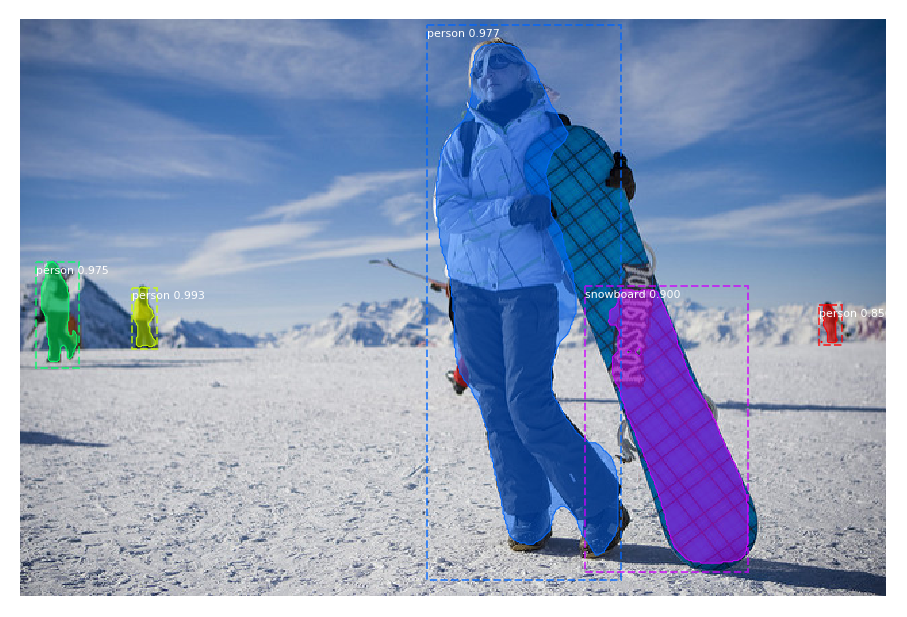

In [9]:
# using random images (from images directory) for inference

img_dir = os.path.join(path_to_repo, 'images')
file_names = os.listdir(img_dir)
img = skimage.io.imread(os.path.join(img_dir, random.choice(file_names)))

out = model.detect([img], verbose=1)

visualize.display_instances(img, out[0]['rois'], out[0]['masks'], out[0]['class_ids'], 
                            class_names, out[0]['scores'])

# Evaluation

In [16]:
def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                # "category_id": 404,
                # "category_id": dataset.get_source_class_id(class_id, "coco"),
                "category_id": dataset.class_info[class_id]['id'],
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results

def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    # Official COCO evaluation

    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()
    cnt = 0
    results = []
    for i, image_id in enumerate(image_ids):
        # print("here ", cnt)
        cnt += 1
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)

In [11]:
dataset_val = CocoDataset()
val_type = "minival"
coco = dataset_val.load_coco(dataset, "minival", return_coco=True)
dataset_val.prepare()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
# Evaluate Object detection 
evaluate_coco(model, dataset_val, coco, "bbox", limit=5000)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [14]:
# Evaluate segmentation
evaluate_coco(model, dataset_val, coco, "segm", limit=5000)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10